In [2]:
from __future__          import division
from scipy.stats         import multivariate_normal
from decimal             import Decimal
import numpy             as np
import array
import math
import struct
import random

TRAIN_IMAGES  = "C:\\Users\\oop\\Desktop\\Winter 2016\\train-images.idx3-ubyte"
TRAIN_LABELS  = "C:\\Users\\oop\\Desktop\\Winter 2016\\train-labels.idx1-ubyte"
TEST_IMAGES = "C:\\Users\\oop\\Desktop\\Winter 2016\\t10k-images.idx3-ubyte"
TEST_LABELS  = "C:\\Users\\oop\\Desktop\\Winter 2016\\t10k-labels.idx1-ubyte"

def read_mnist(images_file, labels_file): 
    f1 = open(labels_file, 'rb')
    magic_number, size = struct.unpack(">II", f1.read(8))
    labels = array.array("b", f1.read())
    f1.close()
    
    f2 = open(images_file, 'rb')
    magic_number, size, rows, cols = struct.unpack(">IIII", f2.read(16))
    raw_images = array.array("B", f2.read())
    f2.close()

    N = len(labels)
    images = np.zeros((N, rows*cols), dtype=np.uint8)
    for i in range(N):
        images[i] = np.array(raw_images[ i*rows*cols : (i+1)*rows*cols ])

    return images, labels

In [3]:
# Read training data.
images_train, labels_train = read_mnist(TRAIN_IMAGES, TRAIN_LABELS)
images_train, labels_train = images_train[:-10000], labels_train[:-10000]
images_validation, labels_validation = images_train[-10000:], labels_train[-10000:]
# Read Test data.
images_test, labels_test = read_mnist(TEST_IMAGES, TEST_LABELS)

In [4]:
# Store the guassian parameters (mean, covariance) for each class i.e digit.
def estimate_parameters(regularization_constant):
    priors = []
    guassians = []
    for digit in range(10):
        data = [image for i, image in enumerate(images_train) 
                 if labels_train[i] == digit]
        priors.append(len(data) / len(images_train))
        mean = np.mean(data, axis=0)
        cov = np.cov(data, rowvar=0) + regularization_constant * np.identity(784)
        guassians.append(multivariate_normal(mean, cov))
    priors = np.array(priors)
    return priors, guassians

def test(images_test, labels_test):
    logpdfs = np.array([guassians[digit].logpdf(images_test) for digit in range(10)]).transpose()
    predicted_digits = np.array([(pdfs + np.log(priors)).argmax() for pdfs in logpdfs])
    test_error = 100 - (labels_test == predicted_digits).sum() * 100 / len(labels_test)
    return test_error

In [5]:
priors, guassians = estimate_parameters(4000)
print test(images_validation, labels_validation)
print test(images_test, labels_test)

4.21
4.29


In [6]:
from pylab import imshow, save, savefig, show
%pylab inline

def print_incorrect_predictions(images_test, labels_test):
    f = np.vectorize(lambda x: Decimal(x).exp())
    lgf = np.vectorize(lambda x: Decimal(x).ln())
    logpdfs = np.array([guassians[digit].logpdf(images_test) for digit in range(10)]).transpose()
    posterior_prob = [f(pdfs + np.log(priors)) / f(pdfs + np.log(priors)).sum() for pdfs in logpdfs]
    incorrect_predictions = []
    for i, image in enumerate(images_test):
        if posterior_prob[i].argmax() != labels_test[i]:
            incorrect_predictions.append((image, posterior_prob[i], labels_test[i]))
    for i in range(5):
        image, probs, label = incorrect_predictions[random.randint(0, len(inc))]
        print "Actual Label: " + str(label) + ", Predicted Label: " + str(probs.argmax())
        imshow(image.reshape(28,28))
        show()
        
        print "Posterior probabilities of classes [0,1,2,3,4,5,6,7,8,9] are:"
        print ["{0:.2E}".format(prob) for prob in probs]
        print "\n"

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Actual Label: 8, Predicted Label: 4


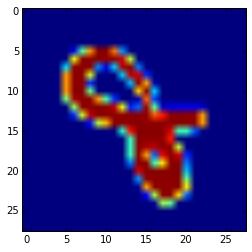

Posterior probabilities of classes [0,1,2,3,4,5,6,7,8,9] are:
['9.97E-69', '5.82E-110', '3.50E-15', '6.96E-17', '9.95E-1', '1.10E-22', '1.19E-47', '1.70E-19', '4.52E-3', '3.81E-23']


Actual Label: 5, Predicted Label: 6


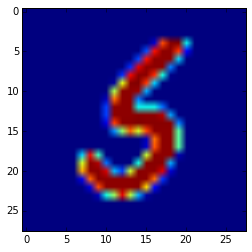

Posterior probabilities of classes [0,1,2,3,4,5,6,7,8,9] are:
['2.62E-18', '8.16E-44', '5.52E-26', '3.84E-7', '1.97E-36', '3.86E-1', '6.14E-1', '2.18E-66', '1.17E-11', '6.14E-36']


Actual Label: 0, Predicted Label: 8


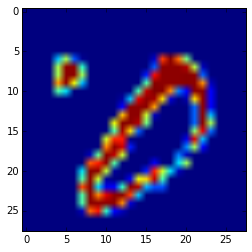

Posterior probabilities of classes [0,1,2,3,4,5,6,7,8,9] are:
['1.22E-3', '1.94E-31', '7.08E-8', '4.11E-3', '8.17E-34', '1.00E-19', '1.16E-39', '1.81E-14', '9.95E-1', '1.95E-30']


Actual Label: 6, Predicted Label: 1


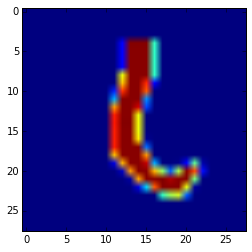

Posterior probabilities of classes [0,1,2,3,4,5,6,7,8,9] are:
['1.31E-36', '1.00E+0', '3.83E-15', '5.41E-24', '8.67E-39', '2.94E-22', '1.13E-8', '5.30E-68', '6.25E-17', '1.90E-55']


Actual Label: 7, Predicted Label: 4


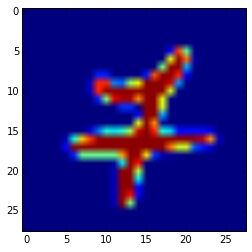

Posterior probabilities of classes [0,1,2,3,4,5,6,7,8,9] are:
['1.24E-55', '5.37E-45', '3.83E-19', '1.21E-31', '9.97E-1', '6.32E-33', '5.27E-43', '2.97E-3', '3.19E-28', '1.08E-21']




In [152]:
print_incorrect_predictions(images_test, labels_test)

In [9]:
def test_with_abstain(images_test, labels_test):
    
    fn = np.vectorize(lambda x: Decimal(x).exp())
    logpdfs = np.array([guassians[digit].logpdf(images_test) for digit in range(10)]).transpose()
    posterior_prob = [fn(pdfs + np.log(priors)) / fn(pdfs + np.log(priors)).sum() for pdfs in logpdfs]
    max_prob = sorted([prob.max() for prob in posterior_prob])
    
    results, results1 = [], []
    for f in np.arange(0.05, 1.05, 0.05):
        # Calculate the appropriate threshold for abstaining.
        threshold = max_prob[int(f * len(max_prob))-1]

        # Calculate the error.
        total_count, error_count = 0, 0
        for i, prob in enumerate(posterior_prob):
            if prob.max() >= threshold:
                total_count += 1
                if prob.argmax() != labels_test[i]:
                    error_count += 1
        results.append((f, error_count * 100 / total_count))
        results1.append((f, total_count/len(max_prob)))
    
    return results, results1

In [12]:
#results, results1 = test_with_abstain(images_test, labels_test)
results1

[(0.050000000000000003, 0.9501),
 (0.10000000000000001, 0.9001),
 (0.15000000000000002, 0.8501),
 (0.20000000000000001, 0.8001),
 (0.25, 0.7501),
 (0.29999999999999999, 0.7001),
 (0.35000000000000003, 0.6501),
 (0.40000000000000002, 0.6001),
 (0.45000000000000001, 0.5501),
 (0.5, 0.5001),
 (0.55000000000000004, 0.4501),
 (0.60000000000000009, 0.4001),
 (0.65000000000000013, 0.3501),
 (0.70000000000000007, 0.3001),
 (0.75000000000000011, 0.2574),
 (0.80000000000000004, 0.2574),
 (0.85000000000000009, 0.2574),
 (0.90000000000000013, 0.2574),
 (0.95000000000000007, 0.2574),
 (1.0, 0.2574)]

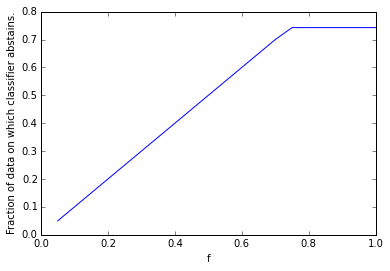

In [13]:
X = [rt[0] for rt in results1]
Y = [1-rt[1] for rt in results1]
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(X,Y)
pyplot.xlabel('f')
pyplot.ylabel('Fraction of data on which classifier abstains.')
pyplot.savefig("f_f.png")

In [71]:
results = test_with_abstain(images_validation, 
                            labels_validation)

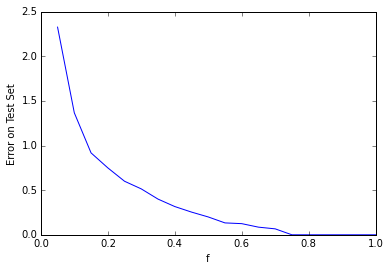

In [100]:
X = [rt[0] for rt in results]
Y = [rt[1] for rt in results]
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(X,Y)
pyplot.xlabel('f')
pyplot.ylabel('Error on Test Set')
pyplot.savefig("Validation_f.png")

In [72]:
d = Decimal('2.910180364521108759829161975E-24')

In [95]:
ppd = lambda x: "{0:.2E}".format(x)

In [94]:
ppd(d)

'2.91E-24'

In [98]:
d = DataFrame(X)

In [102]:
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt

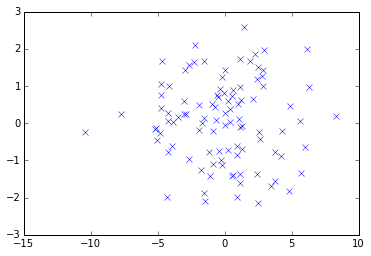

In [110]:
x,y = multivariate_normal(mean=[0,0], cov=[[9,0 ],[0,1]], size=100).T
plt.plot(x, y, 'x')
plt.savefig("2.1.png")

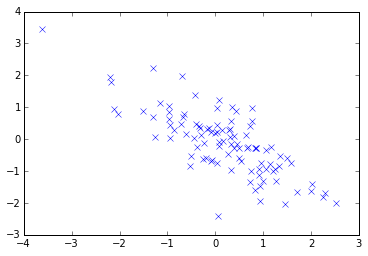

In [111]:
x,y = multivariate_normal(mean=[0,0], cov=[[1,-0.75 ],[-0.75,1]], size=100).T
plt.plot(x, y, 'x')
plt.savefig("2.2.png")

In [112]:
import numpy as np  
import matplotlib.pyplot as plt  
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y)  
    plt.savefig("line.png")

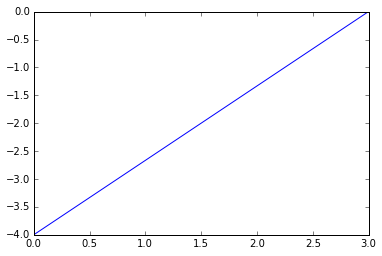

In [113]:
plt.plot([0,3], [-4,0])

In [125]:
x = np.arange(-4, 1)

In [126]:
y = lambda x: (3*x + 12) /4

In [127]:
y(x)

array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ])

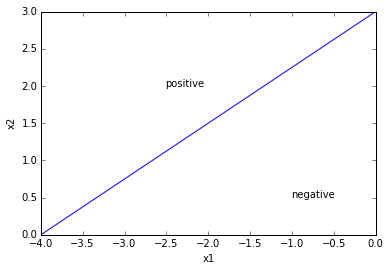

In [142]:
plt.plot(x, y(x))
plt.text(-2.5, 2.0, "positive")
plt.text(-1.0, 0.5, "negative")
plt.xlabel("x1")
plt.ylabel("x2")
plt.savefig("line.png")

(-4, 0.0)
(-3, 0.75)
(-2, 1.5)
(-1, 2.25)
(0, 3.0)
